#**Laboratorio 3: Modelos de decisión lineal y cuadrática**

David Cardenas Peña, PhD.

Edificio de Ingeniería Eléctrica, Oficina 1B-131

email: dcardenasp@utp.edu.co

# Objetivos
* Relacionar las distribuciones de los datos con la clase a la que pertenecen.
* Comprender las etapas de entrenamiento y evaluación de un clasificador.

In [72]:
#Setup libraries
import scipy.linalg
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs,make_circles
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import  LogisticRegression

## Funciones auxiliares

Crean las bases de datos y hacen las gráficas

In [2]:
def blobs():
  #Load database
  X_train, t_train = make_blobs(n_samples=1000, centers=2, random_state=0)
  t_train = t_train*1.0
  N = X_train.shape[0]
  #Data grid to evaluate:
  xmin = X_train.min(0)
  xmax = X_train.max(0)
  x1 = np.linspace(xmin[0], xmax[0], 1000) #Malla de puntos para la variable x1
  x2 = np.linspace(xmin[1], xmax[1], 1000) #Malla de puntos para la variable x2
  X1, X2 = np.meshgrid(x1, x2) #Malla de puntos bi-dimensional
  #Datos para evaluar:
  X_test = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
  Ntest = X_test.shape[0]

  clases = list(set(t_train)) #Hace un set y luego una lista
  print('Clases:',clases)
  return X_train,t_train,X_test

def three_blobs():
  #Load database
  X_train, t_train = make_blobs(n_samples=1000, centers=3, random_state=2)
  t_train = (t_train==2)*1.0
  N = X_train.shape[0]
  #Data grid to evaluate:
  xmin = X_train.min(0)
  xmax = X_train.max(0)
  x1 = np.linspace(xmin[0], xmax[0], 1000) #Malla de puntos para la variable x1
  x2 = np.linspace(xmin[1], xmax[1], 1000) #Malla de puntos para la variable x2
  X1, X2 = np.meshgrid(x1, x2) #Malla de puntos bi-dimensional
  #Datos para evaluar:
  X_test = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
  Ntest = X_test.shape[0]

  clases = list(set(t_train)) #Hace un set y luego una lista
  print('Clases:',clases)
  return X_train,t_train,X_test

def circles():
  #Load database
  X_train, t_train  = make_circles(n_samples=1000, factor=.5,  noise=.1)
  N = X_train.shape[0]
  #Data grid to evaluate:
  xmin = X_train.min(0)
  xmax = X_train.max(0)
  x1 = np.linspace(xmin[0], xmax[0], 1000) #Malla de puntos para la variable x1
  x2 = np.linspace(xmin[1], xmax[1], 1000) #Malla de puntos para la variable x2
  X1, X2 = np.meshgrid(x1, x2) #Malla de puntos bi-dimensional
  #Datos para evaluar:
  X_test = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
  Ntest = X_test.shape[0]

  clases = list(set(t_train)) #Hace un set y luego una lista
  print('Clases:',clases)
  return X_train,t_train,X_test

def plot_boundaries(X_train,t_train,X_test,y_test,boundaries):
  X1 = X_test[:,0].reshape([1000,1000])
  X2 = X_test[:,1].reshape([1000,1000])
  cmap = ['blue','red']
  colors = [cmap[tn] for tn in t_train.astype(int).ravel()]
  plt.figure(figsize=(5,5))
  plt.scatter(X_train[:,0], X_train[:,1], c=colors)#
  cs = plt.contour(X1, X2, y_test.reshape(X1.shape),boundaries)
  plt.clabel(cs, inline=True, fontsize=10)
  plt.show()
  return 

def plot_projected_boundaries(X_train,t_train,X_test,t_test,w,mu,boundaries):

  X1 = X_test[:,0].reshape([1000,1000])
  X2 = X_test[:,1].reshape([1000,1000])

  p = np.linspace(0.2,1.1,1000)
  P1, P2 = np.meshgrid(p,p) #Malla de puntos bi-dimensional
  y_plot = sigmoid(w[0] + w[1]*P1 + w[2]*P2)

  cmap = ['blue','red']
  colors = [cmap[tn] for tn in t_train.astype(int).ravel()]
  
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.scatter(X_train[:,0], X_train[:,1], c=colors)
  plt.scatter(mu[:,0], mu[:,1], c='red',label='Centroids')
  cs = plt.contour(X1, X2, y_test.reshape(X1.shape),boundaries)
  plt.clabel(cs, inline=True, fontsize=10)
  plt.xlabel('$X_1$')
  plt.ylabel('$X_2$')
  plt.legend()

  plt.subplot(1,2,2)
  plt.scatter(Phi_train[:,1], Phi_train[:,2], c=colors)
  cs = plt.contour(P1, P2, y_plot,boundaries)
  plt.clabel(cs, inline=True, fontsize=10)
  plt.xlabel('$\Phi_1$')
  plt.ylabel('$\Phi_2$')
  plt.show()

# Análisis Discriminante Lineal:

## Actividad 1:

Complete la función `lda_fit` para que entregue el vector de proyección LDA `w` y el umbral de clasificación `c`:

$w=S_w^{-1}(\mu_1-\mu_2)$

$c=w^\top(\frac{\mu_1+\mu_2}{2})$

$S_w=\Sigma_1+\Sigma_2$

$\mu_k=mean(X:t==k)$

$\Sigma_k=cov(X:t==k)$

NOTA: Recuerde cómo se indexan filas en matrices

In [3]:
def lda_fit(X,t):

  ind1 = t == 1
  ind2 = t != 1
  mu1 = np.mean(X[ind1], axis=0)
  mu2 = np.mean(X[ind2], axis=0)
  sigma1 = np.cov(X[ind1], rowvar=False)
  sigma2 = np.cov(X[ind2], rowvar=False)
  Sw = sigma1 + sigma2
  w = np.linalg.inv(Sw)@(mu1 - mu2)
  c = np.transpose(w)@((mu1 + mu2)/2)

  return w,c

## Actividad 2:

1. Complete la función `lda_decision_function` para que realice la proyección de las muestras $X$ como:

  $a=Xw$


2. Complete la función `lda_predict` para que realice la clasificación de las muestras como:

  $a>=c\rightarrow y = 1$

  $a<c \rightarrow y = 0$

NOTA: En la función `lda_predict` use el resultado de `lda_decision_function`

In [4]:
def lda_decision_function(X,w):

  a = X@w
    
  return a

def lda_predict(X,w,c):
  
  a = 1.0*[X[:,0]>c]

  y = True
    
  return y

## Evaluar el clasificador:

Ahora empleamos sus funciones para clasificar unas bases de datos.

Clases: [0.0, 1.0]


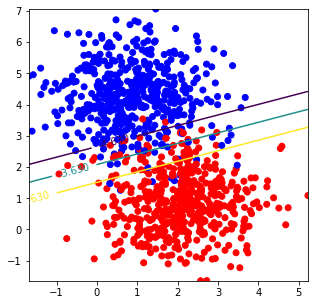

Clases: [0.0, 1.0]


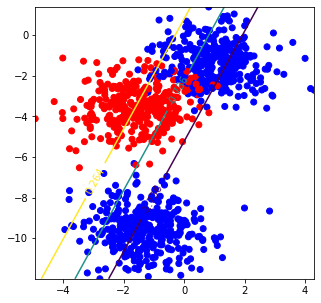

Clases: [0, 1]


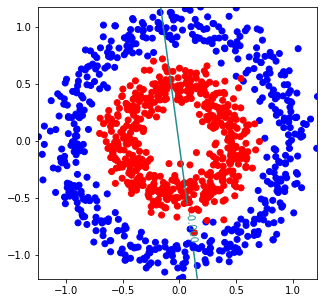

In [5]:
for dataset in [blobs,three_blobs,circles]:
  #Load database
  X_train,t_train,X_test = dataset()

  #Train classifier
  w,c = lda_fit(X_train,t_train)

  #Make predictions
  a_test = lda_decision_function(X_test,w)

  #plot results
  boundaries=[c-1,c,c+1]
  plot_boundaries(X_train,t_train,X_test,a_test,boundaries)

## Actividad 3:
1. Repita la actividad 1 empleando el módulo Linear Discriminant Analysis de scikit-learn (`sklearn.discriminant_analysis.LinearDiscriminantAnalysis`).

2. Guarde en la variable `a_test` el valor de la **función de decisión** del objeto LDA evaluada en los datos `X_test`.

3. Calcule el **acierto** de clasificación en los datos `X_train,t_train` (emplee el método `score` del objeto LDA).


Clases: [0.0, 1.0]
El acierto de clasificación en los datos de entrenamiento es 0.955


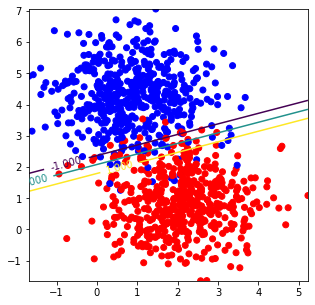

Clases: [0.0, 1.0]
El acierto de clasificación en los datos de entrenamiento es 0.84


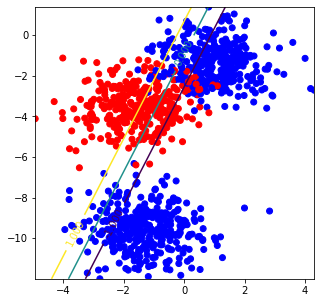

Clases: [0, 1]
El acierto de clasificación en los datos de entrenamiento es 0.504


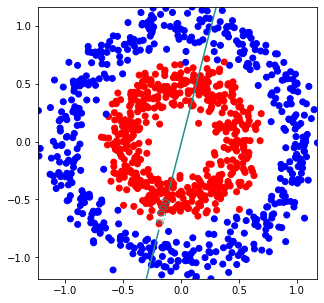

In [6]:
for dataset in [blobs,three_blobs,circles]:
  #Load database
  X_train,t_train,X_test = dataset()

  #Ponga su código acá:
  
  #ind1 = t == 1
  #ind2 = t != 1
  mu1 = np.mean(X_train, axis=0)
  mu2 = np.mean(X_train, axis=0)
  sigma1 = np.cov(X_train, rowvar=False)
  sigma2 = np.cov(X_train, rowvar=False)
  Sw = sigma1 + sigma2
  w = np.linalg.inv(Sw)@(mu1 - mu2)
  c = np.transpose(w)@((mu1 + mu2)/2)  

  w = LinearDiscriminantAnalysis()
  w.fit(X_train, t_train)

  a_test = w.decision_function(X_test)

  acc_train = w.score(X_train, t_train)

  print('El acierto de clasificación en los datos de entrenamiento es {}'.format(acc_train))
  
  #Plot results
  boundaries=[c-1,c,c+1]
  plot_boundaries(X_train,t_train,X_test,a_test,boundaries)

# Análisis Discriminante Cuadrático:


## Actividad 1:
El modelo generativo usa como probabilidad a posteriori de clase una función sigmoide:

$\sigma(a)=\frac{1}{1+exp(-a)}$


Implemente la función sigmoide

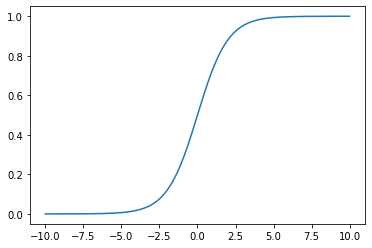

In [7]:
def sigmoid(a):
  s = 1 / (1 + np.exp(-a))
  return s

a = np.linspace(-10,10,1000)
s = sigmoid(a)

plt.plot(a,s)

## Actividad 2:
Si se asumen distribuciones de clase Gaussianas, la frontera de decisión será cuadrática:

$a=-\frac{1}{2}x^\top Ax+b^\top x + c$

donde 

$A=\Sigma_1^{-1}-\Sigma_2^{-1}$

$b=\mu_1\Sigma_1^{-1}-\mu_2\Sigma_2^{-1}$

$c = - \frac{1}{2}(\mu_1^\top\Sigma_1^{-1}\mu_1+\mu_2^\top\Sigma_2^{-1}\mu_2) +log\left\{\left(\frac{|\Sigma_2|}{|\Sigma_1|}\right)^{1/2}\frac{\pi}{1-\pi}\right\}$

Complete la función de decisión.


NOTA: Comparando las ecuaciones acá descritas con las vistas en el curso, se han cambiando algunas transpuestas. Esto se debe a que las muestras se reciben como vector fila y el análisis teórico se realizó con vectores columna.

In [8]:
def quad_decision_function(X,S1,S2,m1,m2,pi):
  #x.shape = (N,D)
  #S1.shape = (D,D)
  #S2.shape = (D,D)
  #m1.shape = (1,D)
  #m2.shape = (1,D)

  #A = np.linalg.inv(np.cov(S1, rowvar=False)) - np.linalg.inv(np.cov(S2, rowvar=False))

  A = np.linalg.inv(S1) - np.linalg.inv(S2)

  b = m1@np.linalg.inv(S1)- m2@np.linalg.inv(S2)

  c = -0.5*(np.transpose(m1)@np.linalg.inv(S1)@m1 - np.transpose(m2)@np.linalg.inv(S2)@m2) + np.log(np.sqrt(np.linalg.det(S2)/np.linalg.det(S1)) * (pi/(1-pi)))  
  
  a = []
  for x_n in X:
    a_n = -0.5*(np.transpose(x_n)@A@x_n) + np.transpose(b)@x_n + c
    a.append(a_n)

  return np.array(a).reshape(X.shape[0],1)
  

## Actividad 3:
La predicción del modelo generativo será entonces
$y = \sigma(a)$

Complete la función de predicción usando sus funciones `quad_decision_function` y `sigmoid`

In [9]:
def quad_predict(X,S1,S2,m1,m2,pi):
  a = quad_decision_function(X,S1,S2,m1,m2,pi)
  y = sigmoid(a)
  return y

## Actividad 4:
Usando máxima verosimilitud, los parámetros del modelo generativo se pueden calcular como

$\Sigma_1 = cov\{x_n:t_n==1\}$

$\Sigma_2 = cov\{x_n:t_n\neq1\}$

$\mu_1 = mean\{x_n:t_n==1\}$

$\mu_2 = mean\{x_n:t_n\neq1\}$

$\pi=\frac{N_1}{N}$

Complete la función de entrenamiento del modelo generativo

In [10]:
def quad_fit(X,t):
  #Recuerde que X.shape=(N,D). Use axis=0 en el cálculo de la media y 
  # rowvar=False en el cálculo de la covarianza

  ind1 = t == 1
  ind2 = t != 1
  N1,_ = np.shape(X[ind1])
  N,_  = np.shape(X) 
  
  m1 = np.mean(X[ind1], axis=0)
  S1 = np.cov(X[ind1], rowvar=False)
  pi = N1/N
  m2 = np.mean(X[ind2], axis=0)
  S2 = np.cov(X[ind2], rowvar=False)
  
  return S1,S2,m1,m2,pi

## Evaluar el clasificador:

Ahora empleamos sus funciones para clasificar unas bases de datos:

Clases: [0.0, 1.0]
Mean 1
[2.07391937 0.89566976]
Covariance 1
[[ 0.95302048 -0.01337776]
 [-0.01337776  0.93525532]]
Mean 2
[0.90568611 4.27535188]
Covariance 2
[[ 0.95302048 -0.01337776]
 [-0.01337776  0.93525532]]
Class 1 prior: 0.5


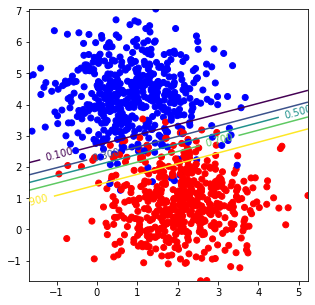

Clases: [0.0, 1.0]
Mean 1
[-1.52351593 -3.4914429 ]
Covariance 1
[[1.01201749 0.11325832]
 [0.11325832 0.94162212]]
Mean 2
[-0.13917698 -5.46127777]
Covariance 2
[[1.01201749 0.11325832]
 [0.11325832 0.94162212]]
Class 1 prior: 0.333


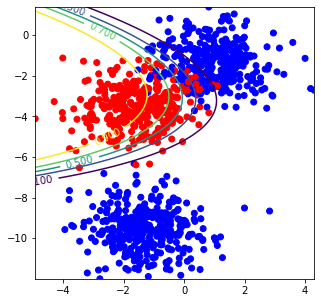

Clases: [0, 1]
Mean 1
[0.00418761 0.00206228]
Covariance 1
[[ 0.13219842 -0.00174177]
 [-0.00174177  0.14278033]]
Mean 2
[ 0.0052339  -0.00492734]
Covariance 2
[[ 0.13219842 -0.00174177]
 [-0.00174177  0.14278033]]
Class 1 prior: 0.5


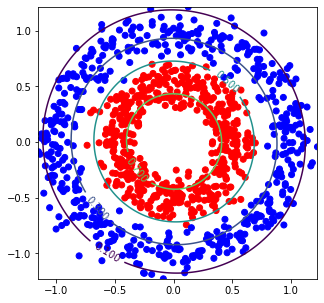

In [11]:
for dataset in [blobs,three_blobs,circles]:
  #Load database
  X_train,t_train,X_test = dataset()

  #Train classifier
  S1,S2,m1,m2,pi = quad_fit(X_train,t_train)

  #Explore parameters
  print('Mean 1')
  print(m1)
  print('Covariance 1')
  print(S1)
  print('Mean 2')
  print(m2)
  print('Covariance 2')
  print(S1)
  print('Class 1 prior: {}'.format(pi))

  #Make predictions
  y_test = quad_predict(X_test,S1,S2,m1,m2,pi)

  #plot results
  boundaries=np.arange(0.1,1,0.2)
  plot_boundaries(X_train,t_train,X_test,y_test,boundaries)

## Actividad 5:
1. Clasifique las bases de datos empleando el módulo Quadratic Discriminant Analysis de scikit-learn (`sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis`).

2. Guarde en la variable `y_test` el valor de la **probabilidad de predicción** para la clase 1 (columna `0` del resultado del método `predict_proba`) del objeto QDA evaluada en los datos `X_test`.

3. Calcule el **acierto** de clasificación en los datos `X_train,t_train` (emplee el método `score` del objeto QDA).

Clases: [0.0, 1.0]
El acierto de clasificación en los datos de entrenamiento es 0.955


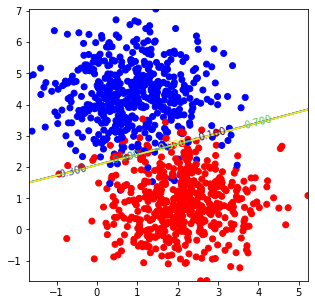

Clases: [0.0, 1.0]
El acierto de clasificación en los datos de entrenamiento es 0.948


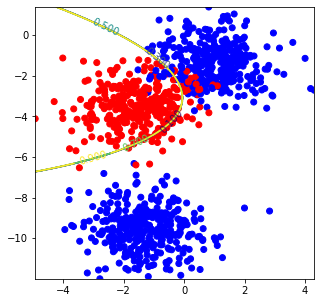

Clases: [0, 1]
El acierto de clasificación en los datos de entrenamiento es 0.984


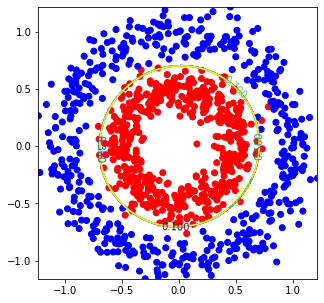

In [130]:
for dataset in [blobs,three_blobs,circles]:
  #Load database
  X_train,t_train,X_test = dataset()

  #Train classifier

  #S1,S2,m1,m2,pi = quad_fit(X_train, t_train)

  ind1 = t_train == 1
  ind2 = t_train != 1
  N1,_ = np.shape(X_train[ind1])
  N,_  = np.shape(X_train) 
  
  m1 = np.mean(X_train[ind1], axis=0)
  S1 = np.cov(X_train[ind1], rowvar=False)
  pi = N1/N
  m2 = np.mean(X_train[ind2], axis=0)
  S2 = np.cov(X_train[ind2], rowvar=False)

  A = np.linalg.inv(S1) - np.linalg.inv(S2)

  b = m1@np.linalg.inv(S1)- m2@np.linalg.inv(S2)

  c = -0.5*(np.transpose(m1)@np.linalg.inv(S1)@m1 - np.transpose(m2)@np.linalg.inv(S2)@m2) + np.log(np.sqrt(np.linalg.det(S2)/np.linalg.det(S1)) * (pi/(1-pi)))  
  
  a = []
  for x_n in X_train:
    a_n = -0.5*(np.transpose(x_n)@A@x_n) + np.transpose(b)@x_n + c
    a.append(a_n)

  a = QuadraticDiscriminantAnalysis()
  a.fit(X_train, t_train)

  #Test classifier
    
  y_test = a.predict(X_test)
  #y_test = a.predict_proba(X_test[:500000, :])

  acc_train = a.score(X_train, t_train)

  print('El acierto de clasificación en los datos de entrenamiento es {}'.format(acc_train))

  #plot results
  boundaries=np.arange(0.1,1,0.2)
  plot_boundaries(X_train,t_train,X_test,y_test,boundaries)

#Regresor logístico:

## Actividad 1:
El regresor logístico tiene como función de costo el negativo de la log-verosimilitud:

$E(w)=-t^\top log(y) - (1-t)^\top log(1-y)$

Complete la función de costo:

In [103]:
def loss(t,y):

  E = -np.transpose(t)@np.log(y) - np.transpose(1-t)@np.log(1-y)  

  return E

## Actividad 2:
El regresor logístico entrega como predicción el posterior de clase objetivo:

$P(C_1|x)=y(x,w)=\sigma(a)$

donde 

$\sigma(a)=\frac{1}{1+exp(-a)}$

y la función de decisión es:

$a=Xw$

Complete la función de predicción.

NOTA: Recuerde que usted ya implementó la función sigmoide $\sigma(a)$ y la función de decisión para un modelo lineal.

In [86]:
def logistic_predict(X,w):
  a = lda_decision_function(X, w)
  y = sigmoid(a)
  return y

## Actividad 3:
El regresor logístico se optmiza mediante gradiente descendiente. El gradiente del costo respecto al vector de parámetros es:

$\nabla E(w) = X^\top(y-t)$

Complete la función de gradiente usando sus funciones `logistic_decision_function` y `sigmoid`



In [87]:
def lr_gradient(w,X,t):  
  y = logistic_predict(X, w)
  grad = np.transpose(X)@(y-t) 
  return grad

## Actividad 4:
Complete el algoritmo de gradiente descendiente:

1.   Inicializar `w` con valores aleatorios de distribución normal (media cero y varianza unitaria). Se debe cumplir que `w.shape=(D,)` siendo `D` el número de características o columnas en `X`.

2.   Predecir con el modelo actual (use `logistic_predict`) en toda la base de datos.

3.   Calcular el costo.

4.   Calcular el gradiente sólo en un subconjuto de la base de datos (use `lr_gradiente`). Consulte el método `np.random.permutation` para generar índices aleatorios.

5.  Actualizar los pesos según la regla del gradente $w(k+1)=w(k)-\eta\nabla E$. La tasa de aprendizaje es un hyperparámetro dado como argumento entrada de la función de entrenamiento.

In [88]:
def logistic_fit(X,t,lr=0.01,maxiter=100):
  #Paso 1: Inicializar w
  w = np.random.normal(0, 1, [X.shape[1],])

  L = [] #Lista para almacenar el costo de cada iteración

  for iter in range(maxiter):
    #Paso 2: Realizar predicciones con el posterior de clase P(C1|x)=y(x,w)
    y = logistic_predict(X, w)
   
    #Paso 3: Calcular el costo
    L.append(loss(t, y))

    #Paso 4: Calcular el gradiente con un subconjunto aleatorio    
    ind = np.random.permutation(500)
    
    grad = lr_gradient(w, X[ind], t[ind])

    #Paso 5: Actualizar los pesos:
    w += -lr *grad

  return w,L

## Actividad 5:

Ahora usamos una base de datos que no es linealmente separable, la proyectamos a un nuevo espacio usando RBFs y usamos un el regresor implementado sobre el espacio proyectado.

*   Cambie el número de iteraciones máximas (`maxiter`) e identifique su efecto.

*   Cambie la tasa de aprendizaje (`lr`) e identifique su efecto.



Clases: [0.0, 1.0]


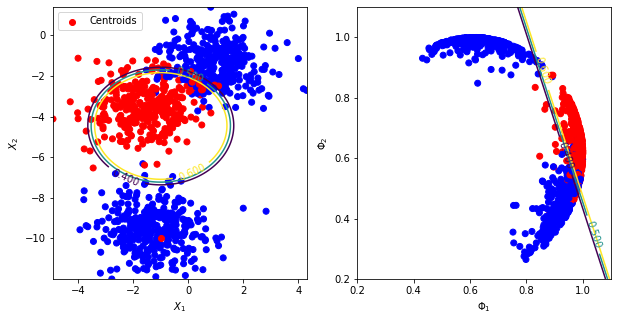

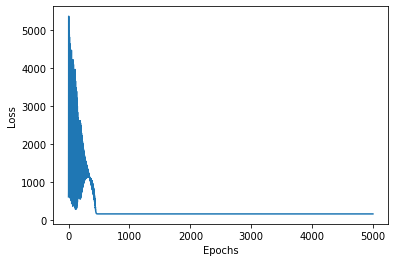

In [89]:
#Basis functions
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import FunctionTransformer

mu = np.array([[-1,-3],[-1,-10]])
rbf = lambda X : np.hstack((np.ones((X.shape[0],1)),rbf_kernel(X,mu,gamma=1e-2)))
transformer = FunctionTransformer(rbf)

#Load database
X_train, t_train, X_test = three_blobs()
t_train = t_train

#Transform data
Phi_train = transformer.fit_transform(X_train)
Phi_test = transformer.fit_transform(X_test)

# Train classfier
w,L=logistic_fit(Phi_train,t_train,lr=0.03,maxiter=5000)

# Make predictions
y_test = logistic_predict(Phi_test,w)

#Plot results
boundaries=[0.4,0.5,0.6]

plot_projected_boundaries(X_train,t_train,X_test,y_test,w,mu,boundaries)

plt.plot(L)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Actividad 6:

1. Clasifique la base de datos anterior empleando el regresor logístico de scikit-learn (`sklearn.linear_model.LogisticRegression`).

2. Guarde en la variable `y_test` el valor de la probabilidad de predicción para la clase 1 (columna `0` del resultado del método `predict_proba`) del objeto Regresor Logístico evaluada en los datos `X_test`.

Clases: [0.0, 1.0]


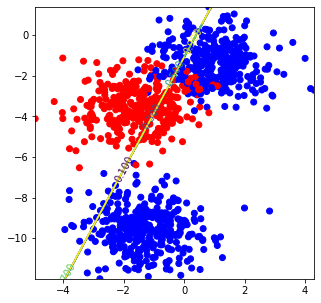

In [131]:
X_train, t_train, X_test = three_blobs()
E = LogisticRegression()
E.fit(X_train, t_train)

y_test = E.predict(X_test)
#y_test = E.predict_proba(X_test[:1000, :])

boundaries=np.arange(0.1,1,0.2)
plot_boundaries(X_train,t_train,X_test,y_test,boundaries)

# Validación cruzada:

## Actividad 1:
La base de datos mnist contiene imágenes de 28 x 28 con dígitos del cero al nueve.


1. Consulte el funcionamiento de la estrategia de validación cruzada (`sklearn.model_selection.cross_validate`)

2. Aplique la validación cruzada a clasificador LDA, QDA y Regresor logístico coon los datos de la base de datos `X` y `t`.

3. Determine el porcentaje de clasificación media y su desviación para cada clasificador.



In [132]:
import pandas as pd
df = pd.read_csv('sample_data/mnist_train_small.csv')

t=df.iloc[:,0]
X=df.iloc[:,1:]

print('La base de datos contiene {} imágenes, cada una con {} pixels'.format(X.shape[0],X.shape[1]))

print('Las clases corresponden a dígitos: {} '.format(np.unique(t)))


La base de datos contiene 19999 imágenes, cada una con 784 pixels
Las clases corresponden a dígitos: [0 1 2 3 4 5 6 7 8 9] 


In [145]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

## Validacion cruzada LDA


In [133]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(X, t)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [142]:
resultadosLDA = cross_validate(LDA, X, t, scoring="accuracy", cv=10)
sorted(cv_resultados.keys())
resultadosLDA['test_score']

array([0.858     , 0.8395    , 0.8545    , 0.8635    , 0.8555    ,
       0.8705    , 0.8645    , 0.8595    , 0.866     , 0.85192596])

In [146]:
resultadosLDA = cross_val_score(LDA, X, t, scoring="accuracy", cv=10)
resultadosLDA

array([0.858     , 0.8395    , 0.8545    , 0.8635    , 0.8555    ,
       0.8705    , 0.8645    , 0.8595    , 0.866     , 0.85192596])

In [155]:
resultadosLDA.mean()*100

85.83425962981491

In [153]:
resultadosLDA.std()

0.0083154687388455

## Validacion cruzada QDA

In [148]:
QDA = QuadraticDiscriminantAnalysis()
QDA.fit(X, t)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [149]:
resultadosQDA = cross_validate(QDA, X, t, cv=10)
sorted(cv_resultados.keys())
resultadosQDA['test_score']

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

array([0.627     , 0.62      , 0.6115    , 0.6175    , 0.643     ,
       0.617     , 0.623     , 0.617     , 0.614     , 0.60530265])

In [150]:
resultadosQDA = cross_val_score(QDA, X, t, scoring="accuracy", cv=10)
resultadosQDA

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

array([0.627     , 0.62      , 0.6115    , 0.6175    , 0.643     ,
       0.617     , 0.623     , 0.617     , 0.614     , 0.60530265])

In [159]:
resultadosQDA.mean()*100

61.953026513256624

In [154]:
resultadosQDA.std()

0.009660774035232427

## Validacion cruzada regresor logistico

In [160]:
clf = LogisticRegression(random_state=0)
clf.fit(X, t)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [161]:
resultadosclf = cross_validate(clf, X, t, cv=10)
sorted(cv_resultados.keys())
resultadosclf['test_score']

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([0.9065    , 0.889     , 0.8965    , 0.9095    , 0.8955    ,
       0.9065    , 0.905     , 0.914     , 0.9065    , 0.89844922])

In [162]:
resultadosclf = cross_val_score(clf, X, t, scoring="accuracy", cv=10)
resultadosclf

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([0.9065    , 0.889     , 0.8965    , 0.9095    , 0.8955    ,
       0.9065    , 0.905     , 0.914     , 0.9065    , 0.89844922])

In [165]:
resultadosclf.mean()*100

90.27449224612306

In [164]:
resultadosclf.std()

0.007201103464896156

# Conclusion

Después de crear los modelos de LDA, QDA y Regresor logístico, podemos decir que una vez aplicada la validación cruzada, el modelo que mejor nos funciona para este caso, es el modelo de regresión logística (clf), ya que con este modelo obtenemos una media de alrededor del 90%

|| *Modelo* || *Mean*  || *Desviación*         ||

|| LDA      || 85.834% || 0.0083154687388455   ||

|| QDA      || 61.953% || 0.009660774035232427 ||

|| clf      || 90.274% || 0.007201103464896156 ||